## Τα Στοιχεία μου
ΤΥΠΑΛΔΟΣ-ΠΑΥΛΟΣ ΑΠΟΣΤΟΛΑΤΟΣ 1115201800009



# Initialisation

In [1]:
!pip install transformers
!pip install wandb

     |████████████████████████████████| 3.5 MB 4.9 MB/s 
     |████████████████████████████████| 596 kB 43.2 MB/s 
     |████████████████████████████████| 67 kB 4.8 MB/s 
     |████████████████████████████████| 6.5 MB 15.0 MB/s 
     |████████████████████████████████| 895 kB 52.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.7 MB 3.9 MB/s 
     |████████████████████████████████| 144 kB 20.7 MB/s 
     |████████████████████████████████| 181 kB 44.4 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=009d3fee1372072cfa955a0df09533a09b0a93db9af5d12305616fa8ebea5a2f
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import nltk
import re
from gensim.models import Word2Vec
from sklearn.metrics import f1_score,recall_score,precision_score,confusion_matrix,classification_report
from gensim.parsing.preprocessing import remove_stopwords
import urllib.request
from scipy import spatial
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# from google.colab import drive
# drive.mount('/content/drive')

import sys, os
from statistics import mean
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from scipy import interp
from itertools import cycle
from torch.autograd import Variable
from torchtext import legacy
from tqdm import tqdm
import tqdm.notebook as tq

from transformers import BertTokenizer
from transformers import BertModel
import json
import logging
# from simpletransformers.question_answering import QuestionAnsweringModel, QuestionAnsweringArgs
from transformers import BertForQuestionAnswering
import textwrap
from transformers import DistilBertTokenizer, DistilBertForQuestionAnswering
from transformers import AutoTokenizer,AdamW,BertForQuestionAnswering

# path = "/content/drive/MyDrive/AI2/" #update this
path = "C:/Users/Pavlos/Desktop/AI2/" #update this
quick_execution=True #update this to True to make all epochs of every model to be quick_global_epoch 


In [3]:
train_df = pd.read_csv(path + "vaccine_train_set.csv",index_col=0)
validation_set = pd.read_csv(path + "vaccine_validation_set.csv",index_col=0) # and this. only those 2 needed to run your own test csv
print(train_df)
print(validation_set)
# print(validation_set.iat[0,0])

                                                   tweet  label
0      Sip N Shop Come thru right now #Marjais #Popul...      0
1      I don't know about you but My family and I wil...      1
2      @MSignorile Immunizations should be mandatory....      2
3      President Obama spoke in favor of vaccination ...      0
4      "@myfoxla: Arizona monitoring hundreds for mea...      0
...                                                  ...    ...
15971  @Salon if u believe the anti-vax nutcases caus...      1
15972  How do you feel about parents who don't #vacci...      0
15973  70 Preschoolers Tested for Measles in Simi Val...      0
15974  Finance Minister: Budget offers room to procur...      0
15975  Are you up to date on vaccines? Take CDC’s vac...      2

[15976 rows x 2 columns]
                                                  tweet  label
0     @user They had a massive surge in with covid d...      1
1     Required vaccines for school: Parents and guar...      0
2     “@KCStar: T

In [4]:
train_df['tweet'] = train_df['tweet'].apply(lambda x: x.lower())
# train_df['tweet'] = train_df['tweet'].apply(lambda x: tokenize(x))
train_df['tweet'] = train_df['tweet'].apply(lambda x: re.sub(r'\W', ' ', x))
train_df['tweet'] = train_df['tweet'].apply(lambda x:re.sub(r'\s+', ' ', x))

validation_set['tweet'] = validation_set['tweet'].apply(lambda x: x.lower())
# validation_set['tweet'] = validation_set['tweet'].apply(lambda x: tokenize(x))

validation_set['tweet'] = validation_set['tweet'].apply(lambda x: re.sub(r'\W', ' ', x))
validation_set['tweet'] = validation_set['tweet'].apply(lambda x:re.sub(r'\s+', ' ', x))


In [5]:
train_df = train_df.drop(train_df[train_df.tweet.str.len() < 2].index)
validation_set = validation_set.drop(validation_set[validation_set.tweet.str.len() < 2].index)

## Αφαίρεση stopwords
i.e “a”, “the”, “is” etc

In [6]:

train_df['tweet'] = train_df['tweet'].apply(lambda x: remove_stopwords(x))
validation_set['tweet'] = validation_set['tweet'].apply(lambda x: remove_stopwords(x))


# Οπτικοποίηση Δεδομένων

In [7]:
print("test set Examples:")
pd.DataFrame(train_df['tweet']).head(10)

test set Examples:


,tweet
0,sip n shop come right marjais popularnobodies ...
1,t know family covid19 vaccine anytime soon
2,msignorile immunizations mandatory period okla...
3,president obama spoke favor vaccination childr...
4,myfoxla arizona monitoring hundreds measles li...
5,whooping cough vaccine day bring baby home t l...
6,prosecutor ken ervin want know recklessly kill...
7,uberfacts average people complain live longer ...
8,legacy jennymccarthy took clothes contributed ...
9,uberfacts average people complain live longer ...


In [8]:
print("validation set Examples:")
pd.DataFrame(validation_set['tweet']).head(10)
# values, counts = np.unique(validation_set['label'], return_counts=True)
# print(values, counts )

validation set Examples:


,tweet
0,user massive surge covid deaths immediately va...
1,required vaccines school parents guardians chi...
2,kcstar johnson county children measles http t ...
3,nv better states best worst vaccinating kids h...
4,like killing w fear mt alyssa_milano vaccine f...
5,m subscribing panic du jour s measles remember...
6,801punx fav songs check aptbs exploding head a...
7,happend covid 19 vaccine test candidates died ...
8,zenith bs gt gt cdc says ebola vaccine works w...
9,dlockyer second occurrence read vaccines harmi...


##GPU

εγώ δούλεψα κυρίως σε google colab αλλα μεταφέρω τους tensors στην gpu για να υποστηρίξω τοπική χρήση pytorch. στον δικο μου υπολογιστή είδα γυρω στο 10% μείωση ταχύτητας

In [9]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
      return torch.device('cuda')
  else:
      return torch.device('cpu')
      
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    elif  isinstance(data, (dict)):#this dict if is buggy
      for d in list(data.values()):
        print(d)
        to_device(d, device)
      return data
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
# train_loader = DeviceDataLoader(train_loader, device)
# val_loader = DeviceDataLoader(val_loader, device)
device = get_default_device()
device
cpudevice =torch.device('cpu')

In [10]:
device

device(type='cuda')

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
class BertClassifier(nn.Module):

    def __init__(self,num_classes, dropout=0.3):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, num_classes)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [12]:
tokens_train = tokenizer.batch_encode_plus(
    train_df['tweet'].tolist(),
    return_tensors="pt",
    max_length = 25,
    padding='max_length',
    pad_to_max_length=True,
    truncation=True
)



# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    validation_set['tweet'].tolist(),
    return_tensors="pt",
    padding='max_length',
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

In [13]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_df['label'].tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(validation_set['label'].tolist())

C:\Users\Pavlos\AppData\Local\Temp/ipykernel_32380/658015210.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_seq = torch.tensor(tokens_train['input_ids'])
C:\Users\Pavlos\AppData\Local\Temp/ipykernel_32380/658015210.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_mask = torch.tensor(tokens_train['attention_mask'])
C:\Users\Pavlos\AppData\Local\Temp/ipykernel_32380/658015210.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_seq = torch.tensor(tokens_test['input_ids'])
C:\Users\Pavlos\AppData\Local\Temp/ipykernel_

In [15]:
batch_size = 64

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)


# dataLoader for train set
train_iterator = DataLoader(train_data,  batch_size=batch_size,shuffle=True)

# wrap tensors
val_data = TensorDataset(test_seq, test_mask, test_y)


# dataLoader for validation set
valid_iterator = DataLoader(val_data, batch_size=batch_size,shuffle=True)

##NEURAL NETWORKS

θα δειτε στην 1 σειρα τα διαγράματα του W2vec και στη 2η του GloVe.αριστερά με το class net1 και δεξιά με το net2

In [16]:
num_classes = 3
learning_rate = 1e-4
model = BertClassifier(num_classes)
loss_func=F.cross_entropy
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
for batch in train_iterator:
  print(batch)
  break

[tensor([[  101,  6117, 12411,  ...,  3501,  2102,   102],
        [  101,  2204,  4436,  ..., 10943,  2098,   102],
        [  101,  5310,  4067,  ...,     0,     0,     0],
        ...,
        [  101,  3571, 28896,  ...,     0,     0,     0],
        [  101,  4067, 18191,  ..., 11311,  9015,   102],
        [  101,  4647, 26378,  ...,   102,     0,     0]]), tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 0, 0]]), tensor([2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 2, 2,
        0, 2, 0, 0, 2, 0, 1, 1, 0, 2, 0, 2, 0, 0, 2, 0, 1, 0, 1, 1, 1, 2, 2, 0,
        2, 2, 0, 0, 1, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1, 2])]


100%|██████████| 10/10 [07:56<00:00, 47.67s/it]


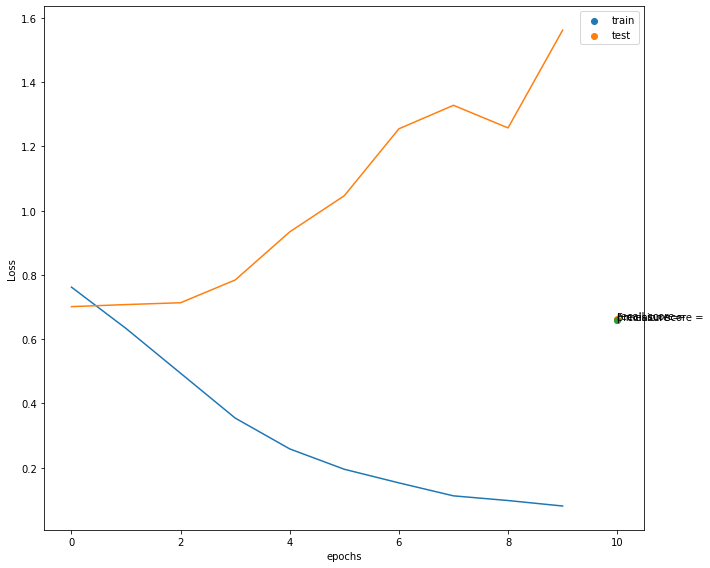

In [18]:


#Initialize dataloader
# plt.subplot(2,2,1)
fig, ax = plt.subplots(1,1)
k=0
store_final=[]
# for embd,(vocab_size,vocabulary) in  enumerate(zip([len(TEXT.vocab)],[TEXT.vocab.vectors])):#pick word embedding


# num_hidden = 50
# num_layers = 2
# #Define Hyperparameters
#Initialize model, loss, optimizer
clip_by_value=True
to_device(model,device)
train_iterator=DeviceDataLoader(train_iterator,device)
valid_iterator=DeviceDataLoader(valid_iterator,device)
# to_device(train_iterator,device)
# to_device(valid_iterator,device)

# to_device(loss_func,device)
train_losses=[]
test_losses=[]
final_output=[]
final_ypred = []
final_label= []
epochs=10
for epoch in tqdm(range(epochs)):
  model.train()#train mode allows for gradient and hyper parameter optimisation.torch.optim takes model.parameters() so it can know which parameters to tweak and which not
  batch_losses = []
  for batch in train_iterator:
    # print( x_batch.shape)

    input_id, mask, labels = batch

    # train_label = train_label.to(device)
    # mask = train_input['attention_mask'].to(device)
    # input_id = train_input['input_ids'].squeeze(1).to(device)

    output = model(input_id, mask)
    # print(output.shape)
    pred_probab = nn.Softmax(dim=1)(output)#activation function
    y_pred = pred_probab.argmax(1)
    loss = loss_func(output, labels) #models always output a one hot vector while y_batch is class number i.e 0 1 2
    batch_losses.append(loss.item())
    
    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    if (clip_by_value):
    # Gradient Norm Clipping
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
    else:  
    #Gradient Value Clipping
      nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()
  
  # print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(trainloader):.5f}")
  train_losses.append(sum(batch_losses)/len(train_iterator))
  with torch.no_grad():
    model.eval()#this eval/test mode will stop the model from training itself for the test dataset by locking down the model parameters and not doing backward probagation
    # scores=[]
    batch_losses = []
    for batch in valid_iterator:
      # val_label = val_label.to(device)
      # mask = val_input['attention_mask'].to(device)
      # input_id = val_input['input_ids'].squeeze(1).to(device)

      input_id, mask, labels = batch

      output = model(input_id, mask)
      pred_probab = nn.Softmax(dim=1)(output)
      y_pred = pred_probab.argmax(1)
      if epoch==epochs-1:#for the final epoch combine the results and store them(the final epoch will have the best results)
        final_output += output
        final_ypred += y_pred
        final_label += labels
      loss = loss_func(output, labels)
      batch_losses.append(loss.item())
    test_losses.append(sum(batch_losses)/len(valid_iterator))
store_final.append((final_output,final_ypred,final_label))
k=k+1
for metric,metric_name in zip([f1_score(torch.tensor(final_label),torch.tensor(final_ypred),average='macro' ),recall_score (torch.tensor(final_label),torch.tensor(final_ypred),average='macro' ) ,precision_score(torch.tensor(final_label),torch.tensor(final_ypred),average='macro' )], ["F measure =","recall score =","precision score ="]):
  plt.scatter([epochs], [metric])
  plt.annotate(metric_name, (epochs, metric))
plt.plot(range(epochs), train_losses)
plt.plot(range(epochs), test_losses)
plt.legend(['train', 'test'])
plt.xlabel("epochs")
plt.ylabel("Loss")
fig.set_figwidth(10)
fig.set_figheight(4*2)
plt.tight_layout()
plt.show()

C:\Users\Pavlos\AppData\Local\Temp/ipykernel_32380/3188264138.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


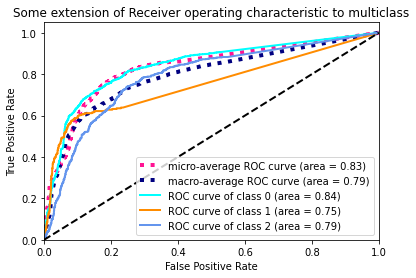

              precision    recall  f1-score   support

  neutral(0)      0.751     0.786     0.768      1065
 anti-vax(1)      0.516     0.544     0.530       296
  pro-vax(2)      0.709     0.659     0.683       921

    accuracy                          0.703      2282
   macro avg      0.659     0.663     0.660      2282
weighted avg      0.704     0.703     0.703      2282



In [19]:
def show_roc():
  num_curves=len(store_final)
  for i in range(num_curves):
    final_output,final_ypred,final_label=store_final[i]
    final_label=[l.cpu() for l in final_label]
    f =[o.tolist() for o in final_output]
    f
    fn = np.array(f)
    fn
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test=label_binarize(final_label, classes=[0, 1, 2])# roc curve function requires one-hot vectors
    y_score=fn
    n_classes=num_classes
    for i in range(n_classes):
        # print(y_test[:, i])#oi ploiades poy einai pragmati tis classis i exoyn 1/true
        # print(y_score[:, i])#oi ploiades poy NOMIZOYN oti einai tis classis i exoyn 1/true
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw = 2
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    # plt.subplot(1, num_curves, i)
    # plt.figure(figsize=(10,10))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Some extension of Receiver operating characteristic to multiclass")
    plt.legend(loc="lower right")
  plt.show()

def report():
  num_curves=len(store_final)
  for i in range(num_curves):
    final_output,final_ypred,final_label=store_final[i]
    final_label=[l.cpu() for l in final_label]
    final_ypred=[l.cpu() for l in final_ypred]
    print(classification_report(final_label, final_ypred, digits=3,target_names=['neutral(0)','anti-vax(1)','pro-vax(2)']))

# print(store_final)
show_roc()
report()

##PART 2

In [5]:
import json
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')
with open( path+"train-v2.0.json", "r") as read_file:
    train = json.load(read_file)
with open( path +"dev-v2.0.json", "r") as read_file:
    test = json.load(read_file)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

In [6]:
o=1
par=0
que=0
cols = ["text","question","is_impossible","answer"]

train_answer_list=[]
comp_list = []

def make_traindf():
  que=0
  for  d in train['data']:
      for p in d["paragraphs"]:
          context=p["context"]
          # par+=1
          # if(o==1):
          #   print(context)
          #   o=0
          for qa in p["qas"]:
              que+=1
              if(quick_execution==True and que==15000):
                return
              question=qa['question']
              answers=qa['answers']
              is_impossible=qa['is_impossible']
              if("plausible_answers" in qa):
                answers=qa['plausible_answers']
              for answer in answers:
                temp_list = []
                temp_list.append(context)
                temp_list.append(question)
                temp_list.append(is_impossible)
                temp_list.append(answer['text'])
                comp_list.append(temp_list)
                train_answer_list.append(answer)
            # else:
              # for a in answers:
                # a=1
que=0
#list of lists to create our dataframe
dev_answer_list=[]
comp_answer_list=[]
def make_dev_df():
  que=0
  for  d in test['data']:
      for p in d["paragraphs"]:
          context=p["context"]
          # par+=1
          # if(o==1):
          #   print(context)
          #   o=0
          for qa in p["qas"]:
              que+=1
              if(quick_execution==True and que==700):
                return
              question=qa['question']
              answers=qa['answers']
              is_impossible=qa['is_impossible']
              if("plausible_answers" in qa):
                answers=qa['plausible_answers']
              comp_answer_list.append(answers)
              for answer in answers:
                temp_list = []
                temp_list.append(context)
                temp_list.append(question)
                temp_list.append(is_impossible)
                temp_list.append(answer['text'])
                comp_list.append(temp_list)
                dev_answer_list.append(answer)
            # else:
              # for a in answers:
                # a=1

make_traindf()
traindf = pd.DataFrame(comp_list, columns=cols) 
comp_list = []

make_dev_df()
dev_df = pd.DataFrame(comp_list, columns=cols) 


In [ ]:
traindf

,text,question,is_impossible,answer
0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,False,in the late 1990s
1,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,False,singing and dancing
2,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,False,2003
3,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,False,"Houston, Texas"
4,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,False,late 1990s
...,...,...,...,...
14994,Some consider storyboards and wordless novels ...,Storyboards and what are thought to be comics ...,False,Wordless novels
14995,Some consider storyboards and wordless novels ...,Storyboards are used a lot by what?,False,Film studios
14996,Some consider storyboards and wordless novels ...,Storyboards are not considered what?,False,an end product
14997,Some consider storyboards and wordless novels ...,Who does not often see storyboards used in fil...,False,the public


In [ ]:
len(dev_answer_list)

1370

In [ ]:
def find_answer_end(texts, answers):
  for answer, text in zip(answers, texts):
      real_answer = answer['text']
      start_idx = answer['answer_start']
      end_idx = start_idx + len(real_answer)

      # Deal with the problem of 1 or 2 character offset 
      if text[start_idx:end_idx] == real_answer:
          answer['answer_end'] = end_idx
      elif text[start_idx-1:end_idx-1] == real_answer:
          answer['answer_start'] = start_idx - 1
          answer['answer_end'] = end_idx - 1  
      elif text[start_idx-2:end_idx-2] == real_answer:
          answer['answer_start'] = start_idx - 2
          answer['answer_end'] = end_idx - 2 

find_answer_end(traindf.text.tolist(), train_answer_list)
find_answer_end(dev_df.text.tolist(), dev_answer_list)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(traindf.text.tolist(), traindf.question.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(dev_df.text.tolist(), dev_df.question.tolist(), truncation=True, padding=True)

In [ ]:
def add_token_positions(encodings, answers):
  start_positions = []
  end_positions = []

  wrong = 0

  for i in range(len(answers)):
    start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
    end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

    # if start position is None, the answer passage has been truncated
    if start_positions[-1] is None:
      start_positions[-1] = encodings.char_to_token(i, answers[i]['answer_start'] - 1)# if position is None, the 'char_to_token' function points to the space after the correct token, so add - 1
      if start_positions[-1] is None:
        start_positions[-1] = tokenizer.model_max_length
      
    
    if end_positions[-1] is None:
      end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - 1)
      if end_positions[-1] is None:
        wrong += 1
        end_positions[-1] = tokenizer.model_max_length

  print(wrong)

  # add them to the dictionary
  encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answer_list)
add_token_positions(val_encodings, dev_answer_list)

2
0


In [ ]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        # print({key: torch.tensor(val[idx]) for key, val in self.encodings.items()})
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [ ]:
learning_rate = 1e-4
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
store_final=[]
train_losses=[]
test_losses=[]
final_output=[]
final_ypred = []
final_label= []
to_device(model,device)
print_every = 1000
epochs=2
for epoch in tqdm(range(epochs)):
  model.train()
  batch_losses = []
  loss_of_epoch = 0
  for batch_idx,batch in enumerate(train_loader): 
    optimizer.zero_grad()
    input_ids = batch['input_ids'].to(device)#i move them here not with DeviceDataloader this time because dictionaries cant be moved to the gpu
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    batch_losses.append(loss.item())
    # do a backwards pass 
    loss.backward()
    # update the weights
    optimizer.step()
    # Find the total loss

  train_losses.append(sum(batch_losses)/len(train_loader))
  with torch.no_grad():
    model.eval()
    batch_losses = []
    for batch_idx,batch in enumerate(val_loader):
      
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        batch_losses.append(loss.item())
    test_losses.append(sum(batch_losses)/len(val_loader))

100%|██████████| 2/2 [54:43<00:00, 1641.96s/it]


In [ ]:
torch.save(model,"/content/drive/MyDrive/finetunedmodel")

In [9]:
# Define the bert tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Load the fine-tuned modeol
model = torch.load("/content/drive/MyDrive/finetunedmodel",map_location=device)
model.eval()

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [7]:
def question_answer(text,question):

  inputs = tokenizer.encode_plus(text, question, return_tensors='pt',truncation=True)
  inputs.to(device)
  outputs = model(**inputs)
  answer_start = torch.argmax(outputs[0])  # get the most likely beginning of answer with the argmax of the score
  answer_end = torch.argmax(outputs[1]) + 1 

  answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

  return answer

In [8]:
import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')


stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))
    
def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

'''remove punctuation, lowercase, stem'''
def normalized_tokens(text):
    return stem_tokens(nltk.word_tokenize(normalize_text(text)))

vectorizer = TfidfVectorizer(tokenizer=normalized_tokens, stop_words='english')

def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]



def compute_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()
    
    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    
    return 2 * (prec * rec) / (prec + rec)


print (cosine_sim(' an old question, but I found this  be done easily', 'ts an old question, but I found this can be done easily with Spacy'))
print (cosine_sim('a little bird', 'a little bird chirps'))
print (cosine_sim('a little bird', 'a little dog barks'))
print (cosine_sim('France', 'france.'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
0.7092972666062737
0.7092972666062738
0.2605556710562624
1.0


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  % sorted(

In [10]:



print (cosine_sim(' an old question, but I found this  be done easily', 'ts an old question, but I found this can be done easily with Spacy'))
print (cosine_sim('a little bird', 'a little bird chirps'))
print (cosine_sim('a little bird', 'a little dog barks'))
print (cosine_sim('France', 'france.'))

0.7092972666062737
0.7092972666062738
0.2605556710562624
1.0


In [11]:
data=dev_df.copy()
del data['answer']
data.drop_duplicates(keep="first" ,inplace=True)
print(len(comp_answer_list))
print(len(data))

699
699


In [14]:
exact_matches=0
faults=0
impossible_detected=0
impossibles=len(data.loc[data['is_impossible'] ==True])
cos_scores=[]
f1_scores=[]
for i,(text,question,is_impossible,answer_list) in tqdm(enumerate(zip(data.text.tolist(),data.question.tolist(),data.is_impossible.tolist(),comp_answer_list)),total= len(data)):
  max_cos=0.0
  max_f1=0.0
  prediction = question_answer(text,question)
  for answer in answer_list:
    answer=answer['text']
    if(compute_exact_match(prediction, answer)):
      exact_matches+=1
    # print("tp",prediction)
    # print("ans",answer)
    # print(i)
    try:
      cos_score = cosine_sim(prediction, answer)# there is a rare occasion where TfidfVectorizer errors out. since it is very rare i set it to 0.0. you can see how many times it happens via 'faults'
    except:
      faults+=1
      cos_score=0.0
    f1_score = compute_f1(prediction, answer)
    max_cos=max(max_cos,cos_score)# you know a question in the dev set can have many answers but bert gives only one. it is fair to set the evalutation of the answer to the similarity with the most similar option of answers.
    max_f1=max(max_f1,f1_score)#for example with question ="what time was the iphone in invented?" answer="2007" , answers=["in the 21st century","2007"] the model's answer shouldnt be weighted down by the "in the 21st century" and get full points
  if(is_impossible==True and not answer):
      impossible_detected+=1
      max_cos=1.0
      max_f1=1.0
  cos_scores.append(max_cos)
  f1_scores.append(max_f1)
print("\n exact matches= ",exact_matches,"out of total=", len(data))
print("average cosine similarity score= ",sum(cos_scores)/len(cos_scores))
print("average f1 score= ",sum(f1_scores)/len(f1_scores))
print("detected ", impossible_detected, " impossible questions out of ",impossibles)
print("faults= ",faults)

100%|██████████| 699/699 [07:32<00:00,  1.54it/s]


 exact matches=  572 out of total= 699
average cosine similarity score=  0.601480603655359
average f1 score=  0.5890473659300481
detected  0  impossible questions out of  363
faults=  3
